In [9]:
# https://stackoverflow.com/questions/50054419/extremely-poor-prediction-lstm-time-series

# Importing the required objects from libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from pandas import DataFrame
from pandas import concat
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT

In [24]:
# productNumber = "12141"
# datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+productNumber+".csv"
# raw = pd.read_csv(datasetTarget, header=0, index_col=0)
raw = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
raw = raw.drop('Month', axis=1)
# print(raw)
sp = 52
epochs = 50
patience = 50
print("raw shape:")
print (raw.shape)
#(1789,5) - 1789 time steps / 5 features
# pipe = TransformerPipeline(steps=[
#         ("imputer", Imputer(method="mean")),
# #         ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#         ("boxcox", BoxCoxTransformer()),
#         ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#         ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
# #     ("differencer", Differencer(lags=1, na_handling='fill_zero')),
# #     ("forecaster", NaiveForecaster(strategy="drift")),
# ])
# raw = pipe.fit_transform(raw)

scaler = MinMaxScaler(feature_range=(0, 1))
raw = scaler.fit_transform(raw)

# raw = np.array(raw)
time_shift = 26 #shift is the number of steps we are predicting ahead
n_rows = raw.shape[0] #n_rows is the number of time steps of our sequence
n_feats = raw.shape[1] #number of features
train_size = int(n_rows * 0.5)
print("train_size : ", train_size)
dropout=0.4
#I couldn't understand how "ds" worked, so I simply removed it because in the code below it's not necessary
#getting the train part of the sequence
train_data = raw[:train_size, :] #first train_size steps, all 5 features
test_data = raw[train_size:, :] #I'll use the beginning of the data as state adjuster
#train_data = shuffle(train_data) !!!!!! we cannot shuffle time steps!!! we lose the sequence doing this
print("train_data : ", train_data.shape, "test_data : ", test_data.shape)
x_train = train_data[:-time_shift, :] #the entire train data, except the last shift steps 
x_test = test_data[:-time_shift,:] #the entire test data, except the last shift steps
x_predict = raw[:-time_shift,:] #the entire raw data, except the last shift steps
print("x_train : ", x_train.shape, "x_test : ", x_test.shape)
y_train = train_data[time_shift:, :]
y_test = test_data[time_shift:,:]
print("y_train : ", y_train.shape, "y_test : ", y_test.shape)
y_predict_true = raw[time_shift:,:]

x_train = x_train.reshape(1, x_train.shape[0], x_train.shape[1]) #ok shape (1,steps,5) - 1 sequence, many steps, 5 features
y_train = y_train.reshape(1, y_train.shape[0], y_train.shape[1])
x_test = x_test.reshape(1, x_test.shape[0], x_test.shape[1])
y_test = y_test.reshape(1, y_test.shape[0], y_test.shape[1])
x_predict = x_predict.reshape(1, x_predict.shape[0], x_predict.shape[1])
y_predict_true = y_predict_true.reshape(1, y_predict_true.shape[0], y_predict_true.shape[1])

print("\nx_train:")
print (x_train.shape)
print("y_train")
print (y_train.shape)
print("x_test")
print (x_test.shape)
print("y_test")
print (y_test.shape)

# print(x_train[0], y_train[0])
# x_train and y_train have overlapping parts


raw shape:
(144, 1)
train_size :  72
train_data :  (72, 1) test_data :  (72, 1)
x_train :  (46, 1) x_test :  (46, 1)
y_train :  (46, 1) y_test :  (46, 1)

x_train:
(1, 46, 1)
y_train
(1, 46, 1)
x_test
(1, 46, 1)
y_test
(1, 46, 1)
[[[0.01544402]
  [0.02702703]
  [0.05405405]
  [0.04826255]
  [0.03281853]
  [0.05984556]
  [0.08494208]
  [0.08494208]
  [0.06177606]
  [0.02895753]
  [0.        ]
  [0.02702703]
  [0.02123552]
  [0.04247104]
  [0.07142857]
  [0.05984556]
  [0.04054054]
  [0.08687259]
  [0.12741313]
  [0.12741313]
  [0.1042471 ]
  [0.05598456]
  [0.01930502]
  [0.06949807]
  [0.07915058]
  [0.08880309]
  [0.14285714]
  [0.11389961]
  [0.13127413]
  [0.14285714]
  [0.18339768]
  [0.18339768]
  [0.15444015]
  [0.11196911]
  [0.08108108]
  [0.11969112]
  [0.12934363]
  [0.14671815]
  [0.17181467]
  [0.14864865]
  [0.15250965]
  [0.22007722]
  [0.24324324]
  [0.26640927]
  [0.2027027 ]
  [0.16795367]
  [0.13127413]
  [0.17374517]
  [0.17760618]
  [0.17760618]
  [0.25482625]
  [0.

In [11]:
model = Sequential()
# model.add(Dense(32))
model.add(LSTM(50, return_sequences=True, input_shape=(None, x_train.shape[2]))) #, input_shape=(None, x_train.shape[2])
# model.add(Dense(128))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dense(256))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dense(256))
# model.add(LSTM(512, return_sequences=True))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dense(128))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dense(64))
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(n_feats, return_sequences=True, dropout=dropout)) 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

[[[0.01544402]
  [0.02702703]
  [0.05405405]
  [0.04826255]
  [0.03281853]
  [0.05984556]
  [0.08494208]
  [0.08494208]
  [0.06177606]
  [0.02895753]
  [0.        ]
  [0.02702703]
  [0.02123552]
  [0.04247104]
  [0.07142857]
  [0.05984556]
  [0.04054054]
  [0.08687259]
  [0.12741313]
  [0.12741313]
  [0.1042471 ]
  [0.05598456]
  [0.01930502]
  [0.06949807]
  [0.07915058]
  [0.08880309]
  [0.14285714]
  [0.11389961]
  [0.13127413]
  [0.14285714]
  [0.18339768]
  [0.18339768]
  [0.15444015]
  [0.11196911]
  [0.08108108]
  [0.11969112]
  [0.12934363]
  [0.14671815]
  [0.17181467]
  [0.14864865]
  [0.15250965]
  [0.22007722]
  [0.24324324]
  [0.26640927]
  [0.2027027 ]
  [0.16795367]]]


/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


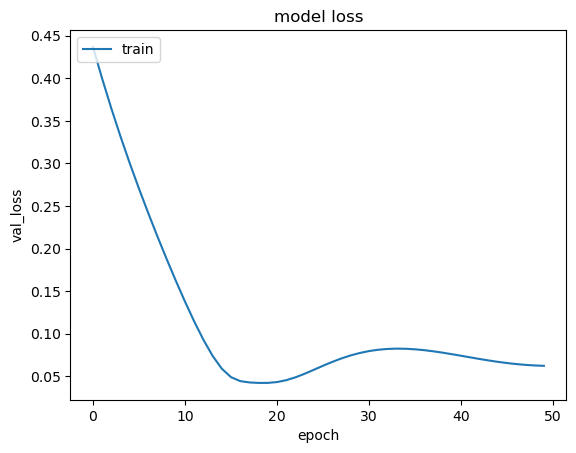

In [12]:
#notice that I'm predicting from the ENTIRE sequence, including x_train      
#is important for the model to adjust its states before predicting the end
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.001)
]
# print(x_train)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=0, validation_data=(x_test,y_test), callbacks=callbacks)
tf.keras.utils.plot_model(model, show_shapes=True)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


y_predict_true:
(1, 118, 1)
y_predict_model: 
(1, 118, 1)
test length: 72


/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


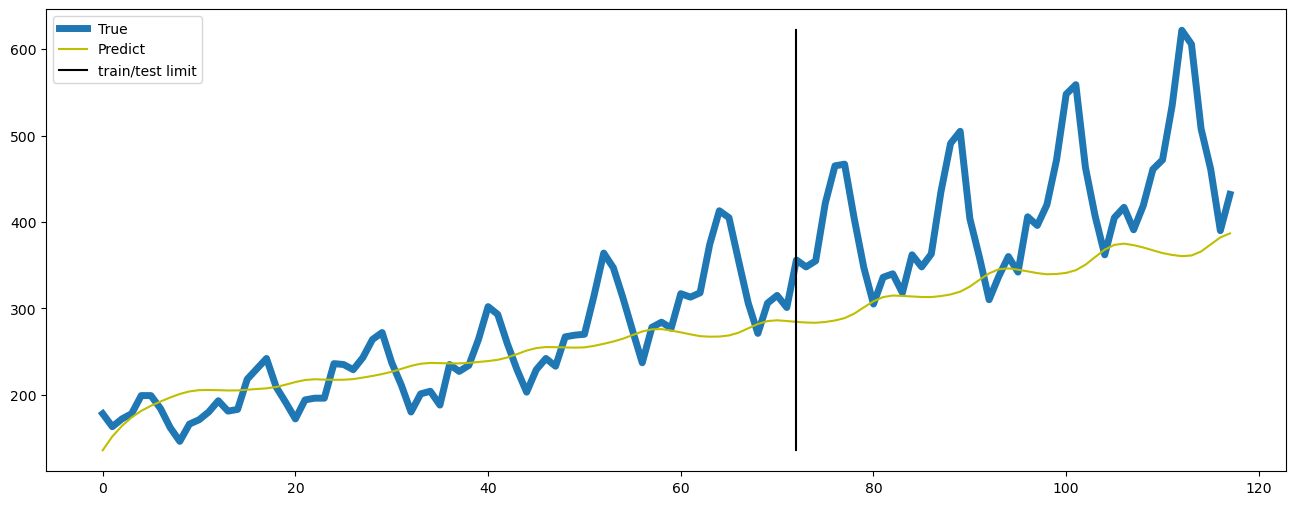

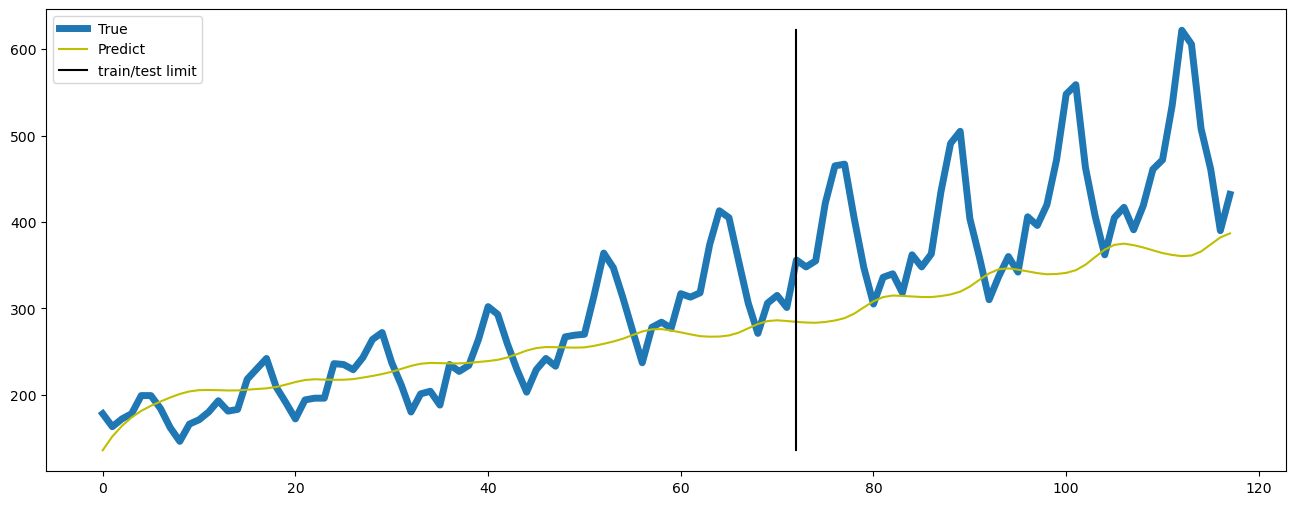

In [13]:
y_predict_model = model.predict(x_predict)

print("\ny_predict_true:")
print (y_predict_true.shape)
print("y_predict_model: ")
print (y_predict_model.shape)
# print(y_predict_true[0,:,0],y_predict_model[0,:,0])
# trainScore = np.sqrt(mean_absolute_percentage_error(y_predict_true[0,:,0], y_predict_model[0,:,0]))
# print('Train Score: %.2f MAPE' % (trainScore))


def plot(true, predicted, divider):

    predict_plot = scaler.inverse_transform(predicted[0])
    true_plot = scaler.inverse_transform(true[0])

    predict_plot = predict_plot[:,0]
    true_plot = true_plot[:,0]

    plt.figure(figsize=(16,6))
    plt.plot(true_plot, label='True',linewidth=5)
    plt.plot(predict_plot,  label='Predict',color='y')

    if divider > 0:
        maxVal = max(true_plot.max(),predict_plot.max())
        minVal = min(true_plot.min(),predict_plot.min())

        plt.plot([divider,divider],[minVal,maxVal],label='train/test limit',color='k')

    plt.legend()
    plt.show()

test_size = n_rows - train_size
print("test length: " + str(test_size))

plot(y_predict_true,y_predict_model,train_size)
plot(y_predict_true[:,-2*test_size:],y_predict_model[:,-2*test_size:],test_size)

In [14]:
from keras2cpp import export_model
export_model(model, 'example.model')